<div style="
    background-color: #0b2343;
    color: white;
    padding: 25px;
    font-family: Arial, sans-serif;
">
<h2 style="margin: 0; font-size: 24px; font-weight: normal;">
    Computational Methods applied to Finance
</h2>
<h1 style="margin: 5px 0 0 0; font-size: 48px; font-weight: bold;">
    Fixed Income
</h1>
<table style="margin: 8px 0 0 0; font-size: 18px">
    <tbody>
        <tr>
            <td style="font-size: 18px; border: none;">Fernando Úbeda Mellina</td>
            <td style="font-size: 18px; border: none;">Alfonso Santos Ramón</td>
        </tr>
        <tr>
            <td style="font-size: 16px; border: none;">fernando.ubeda@uam.es</td>
            <td style="font-size: 16px; border: none;">alfonso.santos@uam.es</td>
        </tr>
    </tbody>
</table>
    
</div>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import pandas as pd
from scipy.optimize import minimize

import numpy as np
import matplotlib.pyplot as plt


$$y(\tau) = \beta_0	+ \beta_1 \left( \frac{1 - e^{-\tau/\lambda}}{\tau/\lambda} \right) +	\beta_2 \left( \frac{1 - e^{-\tau/\lambda}}{\tau/\lambda} - e^{-\tau/\lambda} \right)$$


Decomposition into Three Factors

*	**Level** $(\beta _{0})$: Represents the general level or the long-term (asymptotic) interest rate.
* **Slope** $(\beta _{1})$: Captures the slope of the curve, reflecting short-term interest rates.
* **Curvature** $(\beta_2)$: Describes the “hump” or curvature in the medium-term segment of the yield curve.
* **Decay parameter** $(\lambda)$: Determines the speed at which the slope and curvature components decay as the maturity \tau increases.

Likewise, $y(\tau)$ is the spot interest rate at maturity \tau.

In [ ]:
 # Nelson–Siegel curve functions

def ns_functions(tau, lam):
    """
    Compute the Nelson–Siegel loading functions f1(t) and f2(t).

    Parameters
    ----------
    tau : array-like
        Vector of maturities (in years).
    lam : float
        Decay parameter lambda. Controls how fast the slope
        and curvature components decay with maturity.

    Returns
    -------
    f1, f2 : array-like
        Nelson–Siegel factor loadings:
        f1(t) = (1 - exp(-t / λ)) / (t / λ)
        f2(t) = f1(t) - exp(-t / λ)

    Notes
    -----
    f1(t) captures the *slope* component. It starts at 1 and
    decays monotonically toward 0 as maturity increases.

    f2(t) captures the *curvature* component. It forms a hump
    (first increasing, then decreasing), describing medium-term
    movements in the yield curve.
    """
    f1 = (1 - np.exp(-tau / lam)) / (tau / lam)
    f2 = f1 - np.exp(-tau / lam)
    return f1, f2


In [ ]:
def nelson_siegel_curve(tau, beta0, beta1, beta2, lam):
    """
    Compute the Nelson–Siegel yield curve for given parameters.

    Parameters
    ----------
    tau : array-like
        Vector of maturities (in years).
    beta0 : float
        Level factor (long-term asymptotic rate).
    beta1 : float
        Slope factor (short-term rate adjustment).
    beta2 : float
        Curvature factor (medium-term hump).
    lam : float
        Decay parameter lambda.

    Returns
    -------
    y : array-like
        Spot rates evaluated at each maturity tau.

    Notes
    -----
    The yield curve is constructed as:

        y(t) = β0
             + β1 * f1(t)
             + β2 * f2(t)

    where f1(t) and f2(t) are the Nelson–Siegel loading functions.
    """
    f1, f2 = ns_functions(tau, lam)
    return beta0 + beta1 * f1 + beta2 * f2

In [ ]:
# "Observed" data, generated noise around N-S curve.
np.random.seed(42) # Random seed

# Generate bond maturities
tau_obs = np.linspace(0.1, 30, 30)

# Determine the parameters
beta0_true, beta1_true, beta2_true, lam_true = 3.0, -2.0, 2.0, 2.5

# Estimate the actual NS curve
y_true = nelson_siegel_curve(tau_obs, beta0_true, beta1_true, beta2_true, lam_true)

# Generate observed spot rates (real+noise). Noise is a consequence of measurement errors, market microstructure, differences between instruments...).
y_obs = y_true + np.random.normal(0, 0.1, size=y_true.shape)

print(f"The bond maturities are: {tau_obs}")

The bond maturities are: [ 0.1         1.13103448  2.16206897  3.19310345  4.22413793  5.25517241
  6.2862069   7.31724138  8.34827586  9.37931034 10.41034483 11.44137931
 12.47241379 13.50344828 14.53448276 15.56551724 16.59655172 17.62758621
 18.65862069 19.68965517 20.72068966 21.75172414 22.78275862 23.8137931
 24.84482759 25.87586207 26.90689655 27.93793103 28.96896552 30.        ]


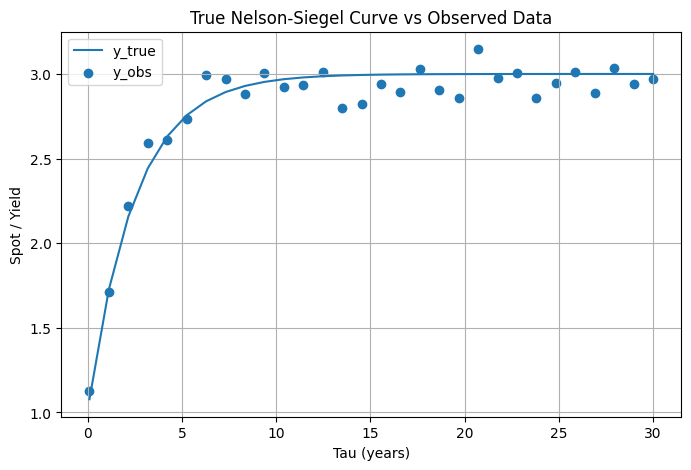

In [ ]:
# Create the plot
plt.figure(figsize=(8,5))
plt.plot(tau_obs, y_true, label="y_true")#plot de la curva
plt.scatter(tau_obs, y_obs, label="y_obs")#plot de los puntos
plt.xlabel("Tau (years)")
plt.ylabel("Spot / Yield")
plt.title("True Nelson-Siegel Curve vs Observed Data")
plt.legend()
plt.grid(True)
plt.show()

* The Nelson–Siegel model is linear in the parameters $\beta$, but not in $\lambda$.

* The parameter $\lambda$ introduces nonlinearity and can make the error function non-convex, potentially generating multiple local minima.

* To avoid this issue, I fix $\lambda$ or perform a grid search over a reasonable range.

* For each value of $\lambda$, the model becomes perfectly linear and convex in $\beta$, allowing me to estimate it using OLS with a unique solution.
* I then select the value of $\lambda$ that minimizes the error.

In this way, I transform a nonlinear and non-convex problem into a sequence of convex problems, obtaining a robust and stable estimation.

$$\left[\begin{array}{c}
y(\tau_1)  \\
y(\tau_2)  \\
\vdots  \\
y(\tau_n)  
\end{array}\right]=\left[\begin{array}{crl}
1 & f_1(\tau_1) &f_2(\tau_1) \\
1 & f_1(\tau_2) &f_2(\tau_2) \\
\vdots &\vdots & \vdots \\
1 & f_1(\tau_n) &f_2(\tau_n)
\end{array}\right]\left[\begin{array}{c}
\beta_0  \\
\beta_1  \\
\beta_1   
\end{array}\right]+\left[\begin{array}{c}
u(\tau_1)  \\
u(\tau_2)  \\
\vdots  \\
u(\tau_n)  
\end{array}\right]$$

$$y=X\beta+u$$

We estimate the parameters by OLS.

$$\hat{\beta}=(XX')^{-1}X'y$$



In [ ]:
# Grid search over lambda + OLS for betas. ORIGINAL Nelson-Siegel model.

# Grid of possible lambda values
lambda_grid = np.linspace(0.1, 5, 100)

# Value to select betas and lambda, starting from infinity
best_sse = np.inf
best_params = None
best_lam = None

for lam in lambda_grid:
    # Calculate the base functions
    f1, f2 = ns_functions(tau_obs, lam)

    # Generate the X matrix
    X = np.column_stack([np.ones_like(tau_obs), f1, f2])

    # Solve the equation by OLS and we are interested in the betas (rank indicates how many columns are linearly independent)
    betas, residuals, rank, s = np.linalg.lstsq(X, y_obs, rcond=None) # (rcond=None: use the default threshold—do not override it.Columns with very small singular values are effectively dropped to avoid multicollinearity issues.)

    # Estimate the Spot values from the betas
    y_fit = X @ betas

    # Estimate the sum of the square of the errors
    sse = np.sum((y_obs - y_fit)**2)

    # We keep the smallest value of the sum of squared residuals and its associated parameters.
    if sse < best_sse:
        best_sse = sse
        best_params = betas
        best_lam = lam

# Identify the betas
beta0_ols, beta1_ols, beta2_ols = best_params

# Estimate the spot rates
y_fit_ols = nelson_siegel_curve(tau_obs, beta0_ols, beta1_ols, beta2_ols, best_lam)

# Estimate the errors
sse_ols = np.sum((y_obs - y_fit_ols)**2)

In [ ]:
print("\n" + "="*50)
print("        Nelson–Siegel Calibration Results")
print("="*50)

print("\n[ OLS with Lambda Grid Search ]")
print(f"  • beta₀ (level)     : {beta0_ols:>10.6f}")
print(f"  • beta₁ (slope)     : {beta1_ols:>10.6f}")
print(f"  • beta₂ (curvature) : {beta2_ols:>10.6f}")
print(f"  • λ (decay factor)  : {best_lam:>10.6f}")
print(f"  • SSE               : {sse_ols:>10.6e}")

print("="*50 + "\n")


        Nelson–Siegel Calibration Results

[ OLS with Lambda Grid Search ]
  • beta₀ (level)     :   2.942195
  • beta₁ (slope)     :  -1.940726
  • beta₂ (curvature) :   2.044878
  • λ (decay factor)  :   2.228283
  • SSE               : 1.880402e-01



The **Levenberg–Marquardt (LM) method** is an algorithm designed to solve nonlinear least-squares problems.

It combines two approaches:
 * The *Gauss–Newton method*, which is fast when the model is close to being linear,
 * The *gradient descent*, which is more stable and is used when Gauss–Newton fails.



In [ ]:
# Function to estimate residuals
def residuals_ns(params, tau, y):
    beta0, beta1, beta2, lam = params
    if lam <= 0:
        lam = 1e-6  # Penalize negative lambdas
    return y - nelson_siegel_curve(tau, beta0, beta1, beta2, lam)

In [ ]:
# Initial point: OLS solution
x0 = np.array([beta0_ols, beta1_ols, beta2_ols, best_lam])

# Apply the optimizer
res_lm = least_squares(
    residuals_ns, x0,
    args=(tau_obs, y_obs),
    method='lm',
    max_nfev=2000
)

# The optimized parameters
beta0_lm, beta1_lm, beta2_lm, lam_lm = res_lm.x

# Estimate the curve
y_fit_lm = nelson_siegel_curve(tau_obs, beta0_lm, beta1_lm, beta2_lm, lam_lm)

# Estimate the residuals
sse_lm = np.sum((y_obs - y_fit_lm)**2)


In [ ]:
# ==============================================
#      Nelson–Siegel Calibration Results
# ==============================================

print("\n" + "="*50)
print("        Nelson–Siegel Calibration Results")
print("="*50)

# ----------- OLS + Lambda Grid Search -----------
print("\n[ OLS with Lambda Grid Search ]")
print(f"  • beta₀ (level)     : {beta0_ols:>12.6f}")
print(f"  • beta₁ (slope)     : {beta1_ols:>12.6f}")
print(f"  • beta₂ (curvature) : {beta2_ols:>12.6f}")
print(f"  • λ (decay factor)  : {best_lam:>12.6f}")
print(f"  • SSE               : {sse_ols:>12.6e}")

# ----------- Levenberg–Marquardt -----------
print("\n[ Levenberg–Marquardt Optimization ]")
print(f"  • beta₀ (level)     : {beta0_lm:>12.6f}")
print(f"  • beta₁ (slope)     : {beta1_lm:>12.6f}")
print(f"  • beta₂ (curvature) : {beta2_lm:>12.6f}")
print(f"  • λ (decay factor)  : {lam_lm:>12.6f}")
print(f"  • SSE               : {sse_lm:>12.6e}")

print("="*50 + "\n")


        Nelson–Siegel Calibration Results

[ OLS with Lambda Grid Search ]
  • beta₀ (level)     :     2.942195
  • beta₁ (slope)     :    -1.940726
  • beta₂ (curvature) :     2.044878
  • λ (decay factor)  :     2.228283
  • SSE               : 1.880402e-01

[ Levenberg–Marquardt Optimization ]
  • beta₀ (level)     :     2.939688
  • beta₁ (slope)     :    -1.935719
  • beta₂ (curvature) :     2.060565
  • λ (decay factor)  :     2.249036
  • SSE               : 1.880104e-01



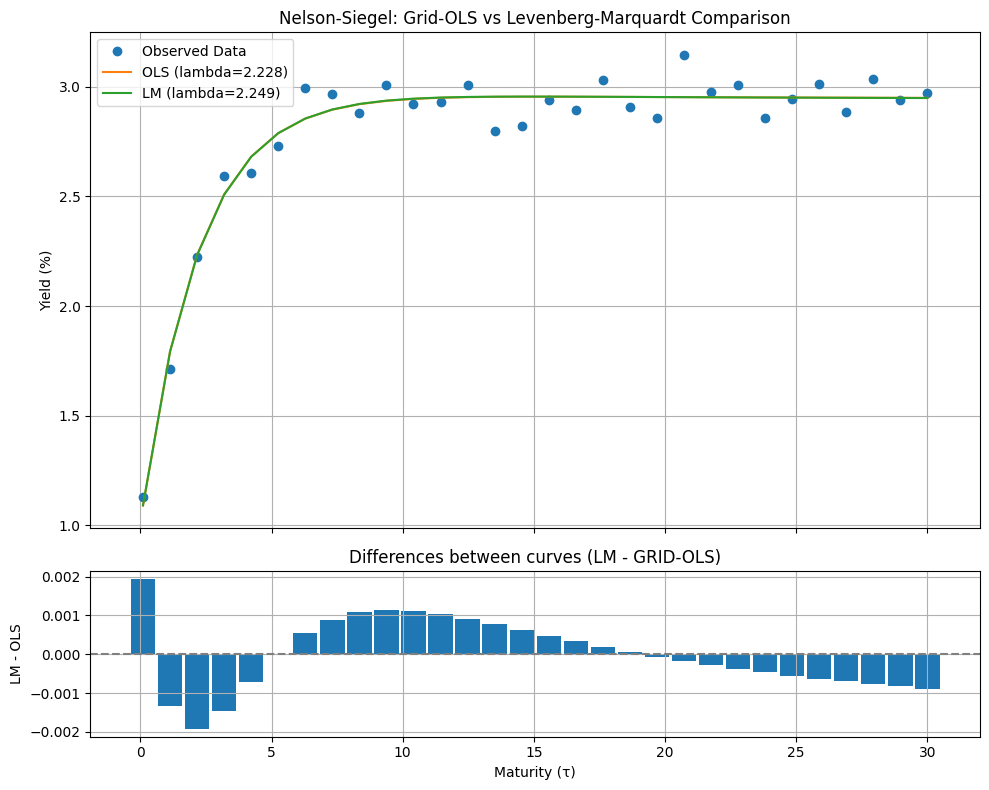

In [ ]:
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(10, 8),
    gridspec_kw={'height_ratios': [3, 1]},
    sharex=True
)

# Curves
ax1.plot(tau_obs, y_obs, 'o', label='Observed Data')
ax1.plot(tau_obs, y_fit_ols, '-', label=f'OLS (lambda={best_lam:.3f})')
ax1.plot(tau_obs, y_fit_lm, '-', label=f'LM (lambda={lam_lm:.3f})')
ax1.set_ylabel("Yield (%)")
ax1.set_title("Nelson-Siegel: Grid-OLS vs Levenberg-Marquardt Comparison")
ax1.grid(True)
ax1.legend()

# LM - OLS Difference
diff = y_fit_lm - y_fit_ols
ax2.bar(tau_obs, diff, width=(tau_obs[1] - tau_obs[0]) * 0.9)
ax2.axhline(0, linestyle='--', color='gray')
ax2.set_xlabel("Maturity (τ)")
ax2.set_ylabel("LM - OLS")
ax2.set_title("Differences between curves (LM - GRID-OLS)")
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
spots_file = "https://docs.google.com/spreadsheets/d/1582BYRQ5JWt_-WTEsqmKNz32Twtyd742/export?format=xlsx"

raw = pd.read_excel(spots_file)
df=raw.copy()
print(df)

    Maturity    Spot
0          1  0.0039
1          2  0.0061
2          3     NaN
3          4     NaN
4          5  0.0166
5          8     NaN
6         10  0.0258
7         15     NaN
8         20     NaN
9         25  0.0332
10        30     NaN


In [ ]:
# 1. Filter only the points where the Spot rate is actually observed

# This boolean mask is True for rows where 'Spot' is not NaN.
mask = df["Spot"].notna()

# Extract the maturities corresponding to observed spot rates.
tau_obs = df.loc[mask, "Maturity"].values

# Extract the observed spot rates (non-missing values).
y_obs = df.loc[mask, "Spot"].values


In [ ]:
# 2. Grid search sobre lambda + OLS en betas
lambda_grid = np.linspace(0.1, 5, 100)
best_sse = np.inf
best_params = None
best_lam = None

for lam in lambda_grid:
    f1, f2 = ns_functions(tau_obs, lam)
    X = np.column_stack([np.ones_like(tau_obs), f1, f2])
    betas, residuals, rank, s = np.linalg.lstsq(X, y_obs, rcond=None)
    y_fit = X @ betas
    sse = np.sum((y_obs - y_fit)**2)

    if sse < best_sse:
        best_sse = sse
        best_params = betas
        best_lam = lam

beta0_ols, beta1_ols, beta2_ols = best_params



In [ ]:
print("\n" + "="*50)
print("        Nelson–Siegel Estimated Parameters")
print("="*50)

print(f"  • beta₀ (level)     : {beta0_ols:>12.6f}")
print(f"  • beta₁ (slope)     : {beta1_ols:>12.6f}")
print(f"  • beta₂ (curvature) : {beta2_ols:>12.6f}")
print(f"  • λ (decay factor)  : {best_lam:>12.6f}")
print(f"  • SSE               : {best_sse:>12.6e}")

print("="*50 + "\n")


        Nelson–Siegel Estimated Parameters
  • beta₀ (level)     :     0.037902
  • beta₁ (slope)     :    -0.032315
  • beta₂ (curvature) :    -0.048290
  • λ (decay factor)  :     1.485859
  • SSE               : 7.680978e-08



In [ ]:
# 3. Compute the Nelson–Siegel curve for all maturities in the table
tau_all = df["Maturity"].values
df["Spot_NS"] = nelson_siegel_curve(tau_all, beta0_ols, beta1_ols, beta2_ols, best_lam)

df

,Maturity,Spot,Spot_NS
0,1,0.0039,0.003873
1,2,0.0061,0.006173
2,3,NaN,0.009693
3,4,NaN,0.013260
4,5,0.0166,0.016445
5,8,NaN,0.023221
6,10,0.0258,0.025997
7,15,NaN,0.029920
8,20,NaN,0.031914
9,25,0.0332,0.033111


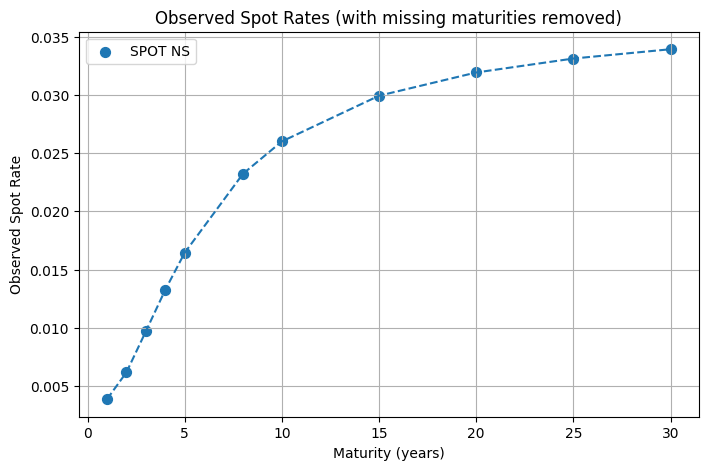

In [ ]:
df_obs = df.dropna()
# Plot
plt.figure(figsize=(8,5))
plt.scatter(df["Maturity"], df["Spot_NS"], label="SPOT NS", s=50)
plt.plot(df["Maturity"], df["Spot_NS"], linestyle="--")
plt.xlabel("Maturity (years)")
plt.ylabel("Observed Spot Rate")
plt.title("Observed Spot Rates (with missing maturities removed)")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
b0 = df.loc[df["Maturity"] == 25, "Spot"].iloc[0]         # long term ~ 25Y
b1=df.loc[df["Maturity"] == 1, "Spot"].iloc[0] - b0       # short term
b2=0                           # sin joroba
l=2                            # 2 year
c0=[b0, b1, b2, l]

In [ ]:
bounds = [
    (0.0, 0.1),   # beta0: 0%–10%
    (-0.1, 0.1),  # beta1
    (-0.1, 0.1),  # beta2
    (0.1, 10.0)   # lambda > 0
]

In [ ]:
def sse_ns(params, tau=tau_obs, y_obs=y_obs):
    beta0, beta1, beta2, lam = params

    # Evitar valores inválidos para lam
    if lam <= 0:
        return 1e10  # penalización enorme

    # Spot estimado por el modelo Nelson–Siegel
    y_hat = nelson_siegel_curve(tau, beta0, beta1, beta2, lam)

    # SSE = suma del cuadrado de los residuos
    sse = np.sum((y_obs - y_hat)**2)
    return sse

By default, the algorithm uses Limited-memory Broyden–Fletcher–Goldfarb–Shanno with Bounds (L-BFGS-B). It is well suited for smooth and nonlinear minimization problems, provided that the constraints are not complex and the parameters are bounded.


In [ ]:
res = minimize(sse_ns, c0, bounds=bounds)
b0_hat, b1_hat, b2_hat, l_hat = res.x

In [ ]:
print(res.x)

[ 0.03893688 -0.03805854 -0.03043295  2.00066193]


In [ ]:
see_rest=sse_ns(res.x, tau=tau_obs, y_obs=y_obs)

In [ ]:
print("\n" + "="*60)
print("        Nelson–Siegel Calibration: Method Comparison")
print("="*60)

# --- GRID + OLS ------------------------------------------------------------
print("\n[ OLS with Lambda Grid Search ]")
print(f"  • beta₀ (level)     : {beta0_ols:>12.6f}")
print(f"  • beta₁ (slope)     : {beta1_ols:>12.6f}")
print(f"  • beta₂ (curvature) : {beta2_ols:>12.6f}")
print(f"  • λ (decay factor)  : {best_lam:>12.6f}")
print(f"  • SSE               : {sse_ols:>12.6e}")

# --- OPTIMIZACIÓN RESTRINGIDA (L-BFGS-B) -----------------------------------
print("\n[ Constrained Optimization (L-BFGS-B) ]")
print(f"  • beta₀ (level)     : {b0_hat:>12.6f}")
print(f"  • beta₁ (slope)     : {b1_hat:>12.6f}")
print(f"  • beta₂ (curvature) : {b2_hat:>12.6f}")
print(f"  • λ (decay factor)  : {l_hat:>12.6f}")
print(f"  • SSE               : {res.fun:>12.6e}")

print("\n" + "="*60 + "\n")


        Nelson–Siegel Calibration: Method Comparison

[ OLS with Lambda Grid Search ]
  • beta₀ (level)     :     0.037902
  • beta₁ (slope)     :    -0.032315
  • beta₂ (curvature) :    -0.048290
  • λ (decay factor)  :     1.485859
  • SSE               : 1.880402e-01

[ Constrained Optimization (L-BFGS-B) ]
  • beta₀ (level)     :     0.038937
  • beta₁ (slope)     :    -0.038059
  • beta₂ (curvature) :    -0.030433
  • λ (decay factor)  :     2.000662
  • SSE               : 9.421227e-07




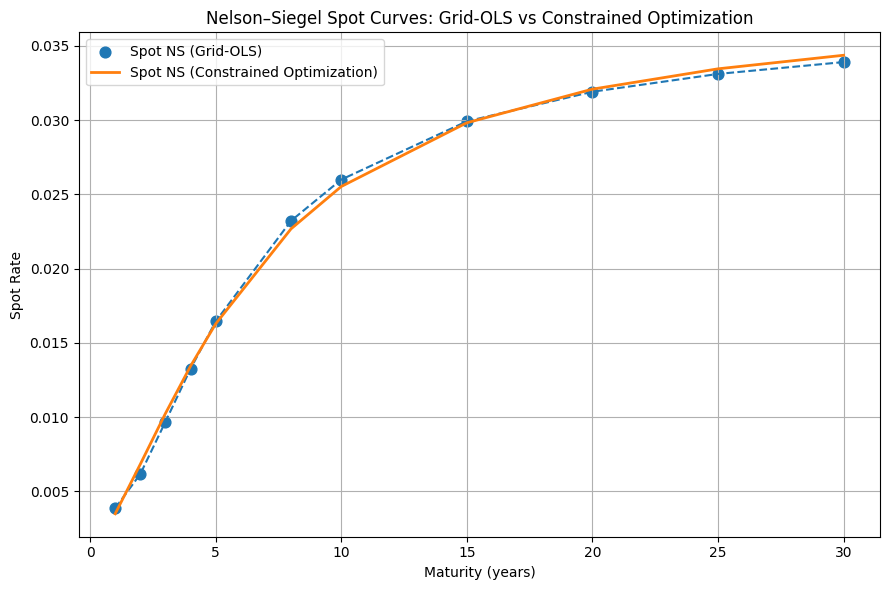

In [ ]:
# ===============================
# Plot: Original NS Spots + Constrained NS Curve
# ===============================

import matplotlib.pyplot as plt

# 1. Extract maturities and NS-fitted spot rates (grid/OLS)
maturity = df["Maturity"].values
spot_ns_grid = df["Spot_NS"].values  # NS curve obtained from grid-search OLS

# 2. Compute the constrained NS curve using restricted parameters
y_hat_rest = nelson_siegel_curve(
    maturity,
    b0_hat, b1_hat, b2_hat, l_hat   # parameters from constrained optimization
)

# 3. Create the figure
plt.figure(figsize=(9,6))

# ---- Original NS Spot curve (Grid + OLS) ----
plt.scatter(maturity, spot_ns_grid, label="Spot NS (Grid-OLS)", s=60)
plt.plot(maturity, spot_ns_grid, linestyle="--")

# ---- Constrained NS Curve ----
plt.plot(
    maturity, y_hat_rest,
    label="Spot NS (Constrained Optimization)",
    linewidth=2
)

# 4. Axis labels and title
plt.xlabel("Maturity (years)")
plt.ylabel("Spot Rate")
plt.title("Nelson–Siegel Spot Curves: Grid-OLS vs Constrained Optimization")

# 5. Format
plt.grid(True)
plt.legend()
plt.tight_layout()

# 6. Show plot
plt.show()